In [1]:
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import networkx as nx # Can show a hückel matrix. 

findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


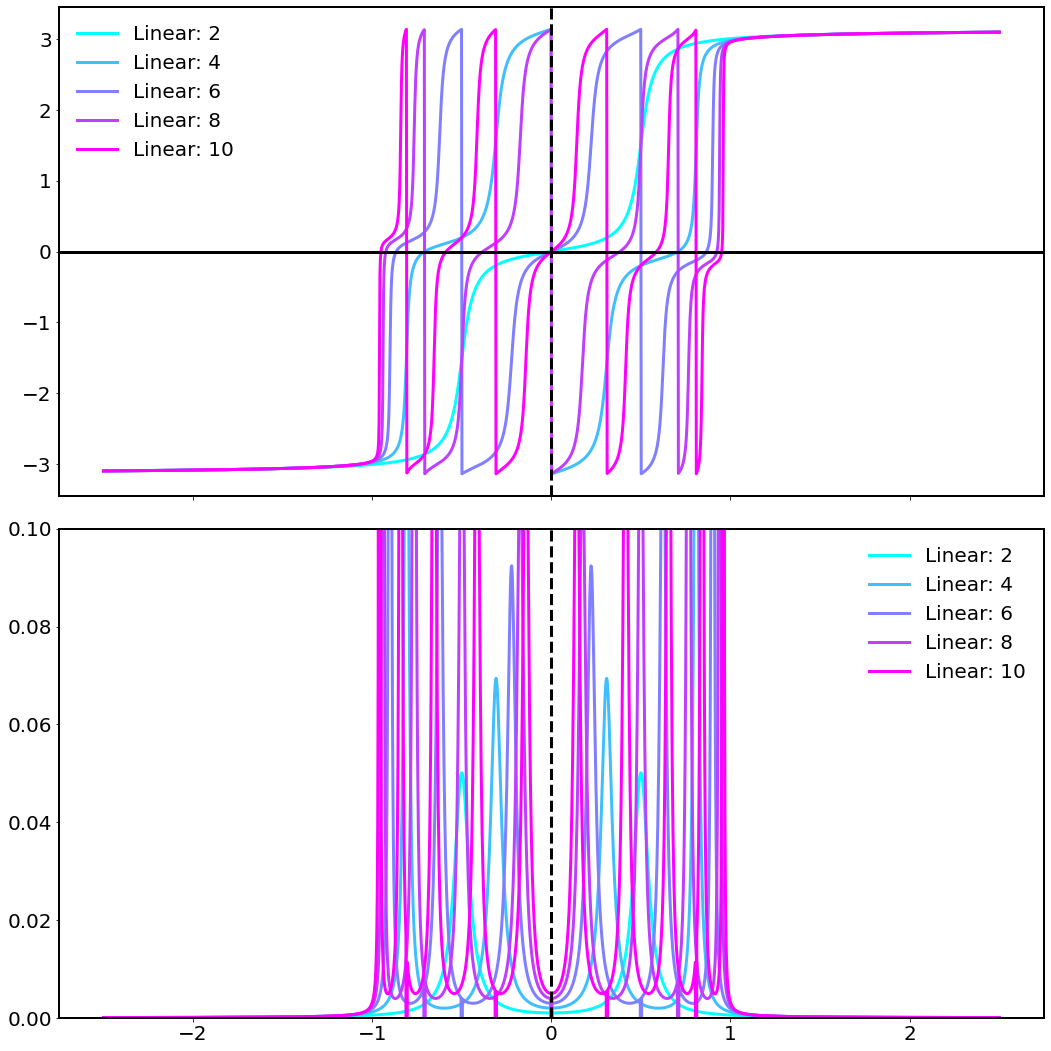

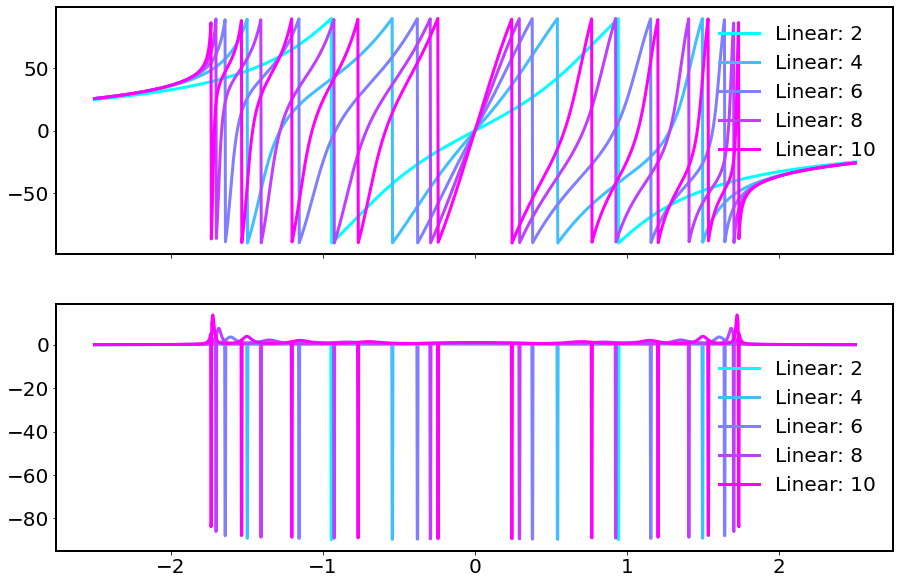

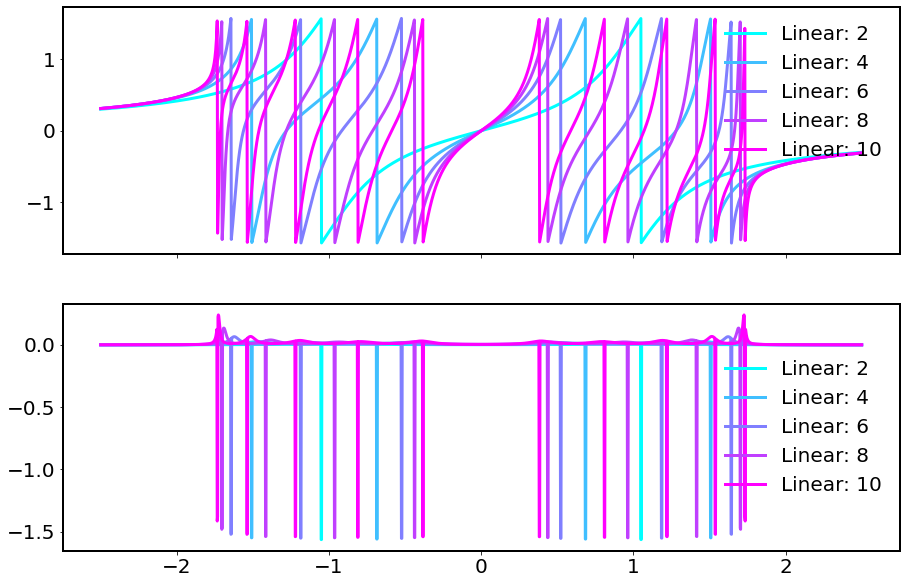

In [2]:

font = {
    "family": "Liberation Sans",
    "weight": "normal",
    "stretch": "normal",
    "size": 20,
}
rc("font", **font)
rc("axes", linewidth=2)
rc("lines", linewidth=3)
c = ["#007fff", "#ff3616", "#138d75", "#7d3c98"]  # Blue, Red, Green, Purple
inv = np.linalg.inv

# A function to create linear molecules: 
def create_linear( 
    molecule_length: int,
    enumerate_electrode: bool = False, # All the parameters with an equal sign are default values: 
    alpha_l: float = 0.0,
    beta: float = -1.0,
    bla: float = 1.0,
    rev_bla: bool = False
):
    """
    Parameters
    ----------
    bla : float
        Bond length alternation. A number between 0 and 1.
    rev_bla : bool
        Whether bond length alternation should be reversed.
        Used to model even [n]cumulenes

    The electrodes are assumed to be on the [0, 0] and [-1, -1] position
    of the Hamiltonian.
    """
    full_length = molecule_length + 2  # To make room for the electrodes
    hamiltonian = np.zeros((full_length, full_length)) # Make a matrix which treat the electrode as a part of the molecule
    hamiltonian[0, 0] = alpha_l # define the strength of the electrode (electrode-electrode coupling??)
    hamiltonian[-1, -1] = alpha_l

    beta_array = np.full(full_length, beta) # make an array with length =number of atoms + 2 electrodes.
                                            # each value of the array is beta. 

    if rev_bla:
        beta_array[::2] *= bla # x*= 3 -> x = x * 3 # if rev_bla = true, then it takes every other value in the beta array, 
                                # and multiplies it with "bla" starting with the first
    else:
        beta_array[1::2] *= bla # if rev_bla = false, then it takes every other value in the beta array, and multiplies
                                # it with "bla" starting with the seccond one. 

    # Hamiltonian is sliced so fill_diagonal() fills the offset diagonal
    np.fill_diagonal(hamiltonian[1:], beta_array) # fills the diagonal (e)
    np.fill_diagonal(hamiltonian[:, 1:], beta_array)

    hamiltonians = []
    if enumerate_electrode: # enumerate = mention a thing - one by one. if TRUE, then remove the last part of the hamiltonian.
        # Remove the original electrode connections # if Flase, then you just keep the electrodes at each end. if True. 
        # then you go over each possible way it can put the other electrode. 
        hamiltonian[-1, molecule_length] = 0
        hamiltonian[molecule_length, -1] = 0

        for pos in np.arange(molecule_length): # pos goes trough numbers from 0 to molecule_length. 
            tmp_hamiltonian = np.empty_like(hamiltonian) #tmp are just a copy of the hamiltonian generated. 
            np.copyto(tmp_hamiltonian, hamiltonian) # copy all the things in tmp_hamiltonian into our hamiltonian
            pos += 1 # add 1 to pos. 
            tmp_hamiltonian[-1, pos] = beta #places beta in the plave where the electrode couple to each molecule. 
            tmp_hamiltonian[pos, -1] = beta
            hamiltonians.append(tmp_hamiltonian)

        return hamiltonians

    return hamiltonian

def draw_graph(hamiltonian) -> None: #what does -> None mean  ??? betyder, at den ikke returnerer noget
    graph = nx.from_numpy_matrix(hamiltonian*-1)
    # Creates colormap where first and last is the electrodes
    color_map = ["blue" for x in graph]
    color_map[0] = "red"
    color_map[-1] = "red"
    nx.draw_networkx(graph, node_color=color_map)


class Junction():
    def __init__( # bliver brugt til at mappe de rigtige ting, de rigtige steder. 
        self, #Hvilken dimension har "self" ??? og hvad er det ??? 
        hamiltonian,
    ) -> None:
        self.hamiltonian_c = hamiltonian[1:-1, 1:-1] #hückle without the electrodes? 
        self.V_l = hamiltonian[0, 1:len(hamiltonian) - 1] 
        self.V_r = hamiltonian[-1, 1:len(hamiltonian) - 1]

        self.gamma_l = np.outer(self.V_l, self.V_l)
        self.gamma_r = np.outer(self.V_r, self.V_r)
        self.gamma_l[self.gamma_l == 0.25] = 0.1
        self.gamma_r[self.gamma_r == 0.25] = 0.1

        self.self_energy = (self.gamma_l + self.gamma_r)*1j/2

    def calc_coupling(self, grid): # cal_coupling
        coupling = []
        for ee in grid:
            ee_diag = np.zeros(self.hamiltonian_c.shape, float)
            np.fill_diagonal(ee_diag, ee)
            H_prime = ee_diag - self.hamiltonian_c + self.self_energy
            G = inv(H_prime)

            gr_vals, gr_vecs = np.linalg.eigh(G) 
            # _, ga_vecs = np.linalg.eigh(G.conj())
            Gr_mo = np.dot(np.dot(gr_vecs, G), inv(gr_vecs)) #MO base ??? 
            # Ga_mo = np.dot(np.dot(ga_vecs, G.conj()), inv(ga_vecs))

            V_lr = np.dot(self.V_l, inv(gr_vecs))
            V_rr = np.dot(gr_vecs, self.V_r)
            # V_la = np.dot(ga_vecs, self.V_l)
            # V_ra = np.dot(self.V_r, inv(ga_vecs))

            t = np.dot(np.dot(V_lr, Gr_mo), V_rr) #Hvilken base er dette i ???
            coupling.append(t)
        return np.array(coupling)


# def main():
alpha = 0
alpha_l, alpha_r = 0.5, 0.5
beta = -0.5

cross = np.array(
    [
        [alpha_l,  0,     beta,  0],
        [0,        alpha, beta,  0],
        [beta,     beta,  alpha, beta],
        [0,        0,     beta,  alpha_r],
    ]
)
para_benz = np.array(
    [
        [alpha_l, 0,     0,     0,     beta,  0,     0,     0],
        [0,       alpha, beta,  0,     0,     0,     beta,  beta],
        [0,       beta,  alpha, beta,  0,     0,     0,     0],
        [0,       0,     beta,  alpha, beta,  0,     0,     0],
        [beta,    0,     0,     beta,  alpha, beta,  0,     0],
        [0,       0,     0,     0,     beta,  alpha, beta,  0],
        [0,       beta,  0,     0,     0,     beta,  alpha, 0],
        [0,       beta,  0,     0,     0,     0,     0,     alpha_l]
    ]
)
meta_benz = np.array(
    [
        [alpha_l, beta,  0,     0,     0,     0,     0,     0],
        [beta,    alpha, beta,  0,     0,     0,     beta,  0],
        [0,       beta,  alpha, beta,  0,     0,     0,     0],
        [0,       0,     beta,  alpha, beta,  0,     0,     0],
        [0,       0,     0,     beta,  alpha, beta,  0,     0],
        [0,       0,     0,     0,     beta,  alpha, beta,  beta],
        [0,       beta,  0,     0,     0,     beta,  alpha, 0],
        [0,       0,     0,     0,     0,     beta,  0,     alpha_l]
    ]
)
four_site_radical = np.array(
    [
        [alpha_l, 0,     beta,  0,     0,     0],
        [0,       alpha, beta,  0,     0,     0],
        [beta,    beta,  alpha, beta,  0,     0],
        [0,       0,     beta,  alpha, beta,  beta],
        [0,       0,     0,     beta,  alpha, 0],
        [0,       0,     0,     beta,  0,     alpha_l]
    ]
)
cross_junction = Junction(cross)
para_junction = Junction(para_benz)
meta_junction = Junction(meta_benz)
radical_junction = Junction(four_site_radical)




grid = np.linspace(-2.5, 2.5, 2000)

# # What do EDGs do? 
# # electron with donating group 
# # Ewg electron without donating droup 
# edg = -3
# length_molecule = 6
# fig, ax = plt.subplots(2, 1,figsize=(15,10), sharex=True)
# colors = plt.cm.cool(np.linspace(0, 1, length_molecule))
# for idx in range(int(length_molecule - length_molecule/2)):
#     mol = create_linear(length_molecule)
#     mol[idx + 1, idx + 1] = edg
#     junc = Junction(mol)
#     coupling = junc.calc_coupling(grid)
#     phase = np.arctan(coupling.imag/coupling.real)
#     ax[0].plot(
#         grid,
#         phase,
#         label=f"{idx}",
#         color=colors[idx],
#     )
#     ax[1].plot(
#         grid,
#         np.gradient(phase),
#         label=f"{idx}",
#         color=colors[idx],
#     )
# plt.legend(frameon=False)
# plt.ylim(0, 0.1)
# ax[0].axvline(0, linestyle="--", c="k")
# ax[1].axvline(0, linestyle="--", c="k")
# fig.tight_layout()
# plt.show()


# # What do EwGs do? 
# # electron with donating group 
# # Ewg electron without donating droup 
# ewg = -3
# length_molecule = 6
# fig, ax = plt.subplots(2, 1,figsize=(15,10), sharex=True)
# colors = plt.cm.cool(np.linspace(0, 1, length_molecule))
# for idx in range(int(length_molecule - length_molecule/2)):
#     mol = create_linear(length_molecule)
#     mol[idx + 1, idx + 1] = edg
#     junc = Junction(mol)
#     coupling = junc.calc_coupling(grid)
#     phase = np.arctan(coupling.imag/coupling.real)
#     ax[0].plot(
#         grid,
#         phase,
#         label=f"{idx}",
#         color=colors[idx],
#     )
#     ax[1].plot(
#         grid,
#         np.gradient(phase),
#         label=f"{idx}",
#         color=colors[idx],
#     )
# plt.legend(frameon=False)
# plt.ylim(0, 0.1)
# ax[0].axvline(0, linestyle="--", c="k")
# ax[1].axvline(0, linestyle="--", c="k")
# fig.tight_layout()
# plt.show()

# # What does electrode position do?
# hamils = create_linear(8, enumerate_electrode=True)
# fig, ax = plt.subplots(2, 1, sharex=True)
# colors = plt.cm.cool(np.linspace(0, 1, len(hamils)))
# for idx, hamil in enumerate(hamils):
#     junc = Junction(hamil)
#     coupling = junc.calc_coupling(grid)
#     phase = np.arctan(coupling.imag/coupling.real)
#     ax[0].plot(
#         grid,
#         phase,
#         label=f"{len(hamil)}",
#         color=colors[idx],
#     )
#     ax[1].plot(
#         grid,
#         np.gradient(phase),
#         label=f"{len(hamil)}",
#         color=colors[idx],
#     )
# plt.legend(frameon=False)
# plt.show()

# molecule_length: int,
#     enumerate_electrode: bool = False, #Hvad betyder dette ??? og hvordan bruger man functionen ??? skal man skrive "True/False"
# #     alpha: float = 0.0,
#     alpha_l: float = 0.0,
#     beta: float = -1.0,
#     bla: float = 1.0,
#     rev_bla: bool = False

# # What does length of the system do?
fig, ax = plt.subplots(2, 1,figsize=(15,15), sharex=True)
lengths = [2, 4, 6, 8, 10]
colors = plt.cm.cool(np.linspace(0, 1, len(lengths))) #color map, cool = hvilken colormap du bruger. 
for idx, length in enumerate(lengths):
    junc = Junction(create_linear(length, beta = -0.5, alpha_l = -0.5))
    coupling = junc.calc_coupling(grid)

    phase = np.arctan2(coupling.imag, coupling.real)
    #np.arctan(coupling.imag/coupling.real) #har ændret til arctan2
    ax[0].plot(
        grid,
        phase,
        label=f"Linear: {length}",
        color=colors[idx]
    )
    ax[1].plot(
        grid,
        np.gradient(phase),
        label=f"Linear: {length}",
        color=colors[idx],
    )
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.ylim(0, 0.1)
ax[0].axvline(0, linestyle="--", c="k")
ax[1].axvline(0, linestyle="--", c="k")
ax[0].axhline(0, c="k")
fig.tight_layout()
plt.show() # angivet i radianer 


# What effect does bond alternation (BLA) have?
fig, ax = plt.subplots(2, 1, figsize=(15,10),sharex=True)
lengths = [2, 4, 6, 8, 10]
colors = plt.cm.cool(np.linspace(0, 1, len(lengths)))
for idx, length in enumerate(lengths):
    junc = Junction(create_linear(length, bla=0.8))
    coupling = junc.calc_coupling(grid)

    phase = np.rad2deg(np.arctan(coupling.imag/coupling.real)) #omregnet til grader. 
    ax[0].plot(
        grid,
        phase,
        label=f"Linear: {length}",
        color=colors[idx]
    )
    ax[1].plot(
        grid,
        np.gradient(phase), # gradienten differentierer phasen som function af energy.  
        label=f"Linear: {length}",
        color=colors[idx],
    )
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.show()

# What effect does reverse BLA have?
fig, ax = plt.subplots(2, 1, figsize=(15,10),sharex=True)
lengths = [2, 4, 6, 8, 10]
colors = plt.cm.cool(np.linspace(0, 1, len(lengths)))
for idx, length in enumerate(lengths):
    junc = Junction(create_linear(length, bla=0.8, rev_bla=True))
    coupling = junc.calc_coupling(grid)

    phase = np.arctan(coupling.imag/coupling.real)
    ax[0].plot(
        grid,
        phase,
        label=f"Linear: {length}",
        color=colors[idx]
    )
    ax[1].plot(
        grid,
        np.gradient(phase),
        label=f"Linear: {length}",
        color=colors[idx],
    )
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.show()

# # if __name__ == "__main__":
# #     exit(main())


In [3]:
print(cross_junction.gamma_l)


[[ 0.  -0. ]
 [-0.   0.1]]


In [4]:
beta_array = np.full(10, 2)
beta_array[1::2] *= 4
print(beta_array)

[2 8 2 8 2 8 2 8 2 8]


In [5]:
hamiltonian = np.zeros((10+2, 10+2))
np.fill_diagonal(hamiltonian[1:], beta_array)
np.fill_diagonal(hamiltonian[:, 1:], beta_array)
print(hamiltonian)

[[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 8. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 8. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]


In [6]:
hamiltonian[-1, 10] =0 
hamiltonian[10, -1] = 0
print(hamiltonian)

[[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 8. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 8. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
hamiltonian[-1, 10] =0 
hamiltonian[10, -1] = 0
print(hamiltonian)

np.arange(10)
tmp_hamiltonian = np.empty_like(hamiltonian)
print(tmp_hamiltonian)
v = np.copyto(tmp_hamiltonian, hamiltonian)
print(v)

[[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 8. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 8. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[            nan 0.00000000e+000 1.18597778e-311 1.18542100e-311
  0.00000000e+000             nan             nan 0.00000000e+000
  2.11337364e+214 0.00000000e+000 4.44659081e-323 1.18597778e-311]
 [1.18542100e-311             nan 0.00000000e+000             nan
  0.00000000e+000 8.55064458e-072 3.55727265e-322 5.43472210e-323
  1.18597778e-311 1.18542100e-311 5.43472210e-323 1.38338381e-322]
 [            nan 0.00000000e+000 1.11789332e+253 7.11454530e-322
  5.43472210e-323 1.18597778e-311 1.18542100e-311             nan
 

In [8]:
V_lr = np.dot(self.V_l, inv(gr_vecs))
V_rr = np.dot(gr_vecs, self.V_r)

NameError: name 'self' is not defined

In [ ]:
tmp_hamiltonian[-1, 1] = 2
tmp_hamiltonian[1, -1] = 2
print(tmp_hamiltonian)
print(tmp_hamiltonian[1:-1, 1:-1])

In [ ]:
graph = nx.from_numpy_matrix(hamiltonian*-1)
print(graph)

In [ ]:
create_linear(4,True, 1,1,-1,0.5,True)

In [ ]:
create_linear(
    molecule_length: 2,
    enumerate_electrode: bool = , #Hvad betyder dette ???
    alpha: float = 0.0,
    alpha_l: float = 0.0,
    beta: float = -1.0,
    bla: float = 1.0,
    rev_bla: bool = True

In [ ]:
fig, ax = plt.subplots(2, 1,figsize=(15,10), sharex=True)

In [ ]:

draw_graph(create_linear(4))

In [ ]:

draw_graph(create_linear(2))

In [ ]:

draw_graph(create_linear(5))